In [34]:
# from google.colab import drive
# drive.mount('/content/drive')

In [35]:
# from google.colab import drive
# drive.mount('/content/drive')
import os
#os.chdir("/content/drive/MyDrive/Colab Notebooks/TOpo")
# https://www.mlpack.org/doc/mlpack-3.0.4/python_documentation.html#emst

In [36]:
#!pip install mlpack

In [37]:
from operator import ge
import geomutils
from DisjointSets import DisjointSets
from scipy import spatial, sparse
import numpy as np
from mlpack import emst
import matplotlib.pyplot as plt

class TopoMap:
    def __init__(self, emstLeafSize = 1, verbose = False):
        self.verbose = None
        self.leafSize = emstLeafSize
        self.compMap = []
        self.verts = []
        self.comps = set()

    def project(self, data: np.ndarray, dimension:int):
        localEdges = []
        localWeights = []

        print("computing emst")
        self.emst(data,dimension,localEdges,localWeights)
        print("placing points")
        return self.placePoints(localEdges,localWeights)

    def emst(self, data:np.ndarray, dim:int, edges, weights) -> None:
        pts = data
        emst_result = emst(input=pts, leaf_size=1, naive=False)
        E_emst = emst_result['output']
        for idx in range(len(E_emst)):
            point1, point2, edge = E_emst[idx]
            point1, point2 = int(point1), int(point2)
            if point2>point1:
                edges.append([point1, point2])
            else:
                edges.append([point2, point1])
            weights.append(edge)

    def sortEdges(self, weights):
        weights_list = []
        for idx in range(len(weights)):
            weights_list.append([weights[idx], idx])
        weights_list.sort(key = lambda x: x[0])
        weights.sort()
        order = []
        for idx in range(len(weights)):
            order.append(weights_list[idx].pop())
        return order

    def placePoints(self,edges:list, weights:list):
        if len(edges) != len(weights):
            raise ValueError("edges and lengths don't match")
        comps = DisjointSets(len(edges) + 1)
        self.compMap.clear()
        # self.verts #P_i = {(0,0)}
        for i in range(len(edges) + 1):
            newVert = geomutils.Vertex(geomutils.Point(0,0),i)
            self.verts.append(newVert)

            newCM = geomutils.Component()
            newCM.vertices.append(i)
            newCM.hull.append(self.verts[i].p)
            newCM.hull.append(self.verts[i].p)
            self.compMap.append(newCM)

        order = self.sortEdges(weights) #这又是什么？？
        
        for _i in range(len(order)):
            i = order[_i]
            p1 = edges[i][0]
            p2 = edges[i][1]
            try:
                c1 = comps.find(p1)
                c2 = comps.find(p2)
            except:
                print(comps.set)
                print(p1,p2)
                print("something wrong")
                raise

            if c1 == c2:
                raise ValueError("Error!!! MST edge belongs to the same component!!!") 

            comp1 = self.compMap[c1]
            comp2 = self.compMap[c2]
            comp = self.mergeComponents(comp1,comp2,p1,p2,weights[i])
            comps.merge(c1,c2)

            c = comps.find(c1)
            self.compMap[c] = comp 
        pts = []
        for i in range(len(self.verts)):
            pts.append(self.verts[i].p)
        return pts

    def allighHull(self,hull,p:geomutils.Point,topEdge:bool) ->geomutils.Transformation:
        v= -1
        for i in range(len(hull)):
            d = geomutils.distance2(hull[i],p)
            if v == -1:
                d2 = d
                v = i
            elif d2 > d:
                d2 = d
                v = i
        
        v1 = geomutils.Point()
        v2 = geomutils.Point()
        if topEdge:
            v1 = hull[v]
            v2 = hull[v+1]
        else:
            if v ==0:
                v = len(hull)-1
            v1 = hull[v]
            v2 = hull[v-1]

        trans = geomutils.Transformation(-1*hull[v].x,-1*hull[v].y,0,1)
        if (len(hull)>2):
            geomutils.findAngle(v1,v2,trans)
        else:
            trans.sin = 0
            trans.cos = 1
        return trans

    
    def transform(self,p:geomutils.Point,t:geomutils.Transformation,yOffset:float) -> geomutils.Point:
        x = p.x + t.tx
        y = p.y + t.ty
        xx = x * t.cos - y * t.sin
        yy = x*t.sin + y * t.cos
        yy += yOffset
        return geomutils.Point(xx,yy)

    def transformComponent(self,c:geomutils.Component,t:geomutils.Transformation,yOffset:float) -> None:
        for i in range(len(c.vertices)):
            vin = c.vertices[i]
            self.verts[vin].p = self.transform(self.verts[vin].p,t,yOffset)

    
    def mergeComponents(self,c1:geomutils.Component,
            c2:geomutils.Component,v1:int,v2:int,length:float) -> geomutils.Component:
        merged = geomutils.Component()
        merged.vertices.clear()
        merged.vertices.extend(c1.vertices)
        merged.vertices.extend(c2.vertices)
        merged.hull.clear()

        if length > 0:
            # print("C1",c1.hull, self.verts[v1].p)
            t1 = self.allighHull(c1.hull,self.verts[v1].p,True)
            self.transformComponent(c1,t1,0)

            # print("C2",c2.hull, self.verts[v2].p)
            t2 = self.allighHull(c2.hull,self.verts[v2].p,False)
            self.transformComponent(c2,t2,length)

            pts = np.zeros((len(c1.hull)+len(c2.hull)-2,2))
            for i in range(len(c1.hull)-1):
                temp_P = self.transform(c1.hull[i],t1,0)
                pts[i,0], pts[i,1] = temp_P.x, temp_P.y
            for i in range(len(c2.hull)-1):
                temp_P = self.transform(c2.hull[i],t2,length)
                pts[len(c1.hull)-1+i,0], pts[len(c1.hull)-1+i,1] = temp_P.x, temp_P.y
            # print(pts)
            hull_list = geomutils.computeConvexHull(pts,[])
            # For this part, we need to decide keeping Points type or a 2-1 np array
            merged.hull = [geomutils.Point(float(each[0]), float(each[1])) for each in hull_list]
            #这里怎么接这个语句的返回值啊？
            # 不用接，这玩意in-place
            # 但这里有个Python posional argument 的 bug 我怎么都想不明白
        else:
            if len(c1.hull) !=2 or len(c2.hull) != 2:
                raise ValueError("Error!!! hull cannot have more than one point when edge lenght is 0!!!")
            
            merged.hull.append(c2.hull[0])
            merged.hull.append(c2.hull[1])
        return merged




In [38]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, :] 
y = iris.target

In [39]:
test = TopoMap()
output = test.project(X,len(X[0]))
print(len(output))

computing emst
placing points
150


In [40]:
rgbs = ['blue','red','greene']
colors = [rgbs[y[i]] for i in range(len(y))]

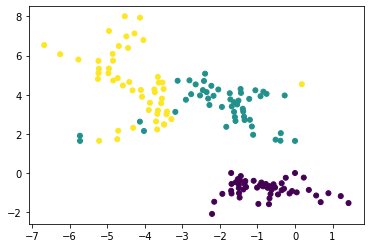

In [41]:

import time

# for r in range(85):
#   topore = np.array([[each.x, each.y] for each in output])[:r].T
#   plt.scatter(topore[0],topore[1], c=y[:r])
#   plt.show()
#   time.sleep(0.9)
#   plt.clf()
topore = np.array([[each.x, each.y] for each in output]).T
plt.scatter(topore[0],topore[1], c=y, s=5**2)

In [42]:
dig = datasets.load_digits()
X = dig.data
y = dig.target

In [43]:
print(X.shape)

(1797, 64)


In [57]:
test = TopoMap()
output = test.project(X,len(X[0]))
print(len(output))
X.shape

computing emst
placing points
1797


(1797, 64)

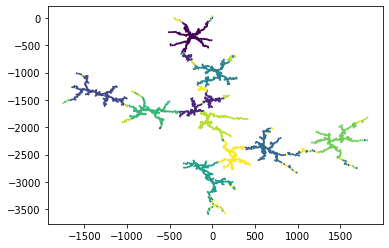

In [45]:
topore = np.array([[each.x, each.y] for each in output]).T
plt.scatter(topore[0],topore[1], c=y, s=1**2)

### TopoMap with selected dimensions

computing emst
placing points


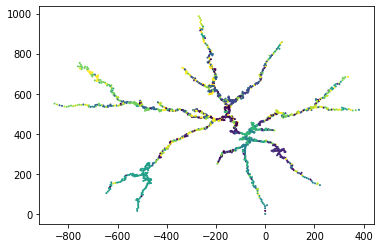

In [59]:
dig = datasets.load_digits()
X = dig.data
Y = dig.target
test = TopoMap()
output = test.project(X[:,0:16],len(X[0]))
topore = np.array([[each.x, each.y] for each in output]).T
plt.scatter(topore[0],topore[1], c=Y, s=1**2)

computing emst
placing points


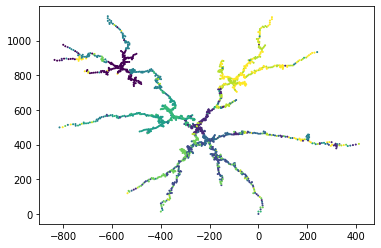

In [58]:
dig = datasets.load_digits()
X = dig.data
Y = dig.target
test = TopoMap()
output = test.project(X[:,16:32],len(X[0]))
topore = np.array([[each.x, each.y] for each in output]).T
plt.scatter(topore[0],topore[1], c=Y, s=1**2)

computing emst
placing points


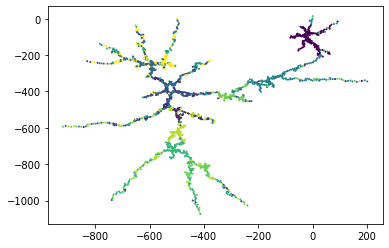

In [60]:
dig = datasets.load_digits()
X = dig.data
Y = dig.target
test = TopoMap()
output = test.project(X[:,32:48],len(X[0]))
topore = np.array([[each.x, each.y] for each in output]).T
plt.scatter(topore[0],topore[1], c=Y, s=1**2)

computing emst
placing points


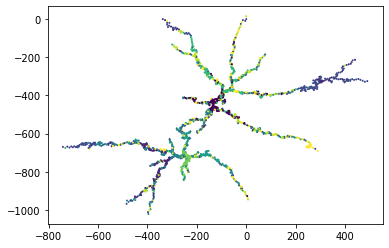

In [61]:
dig = datasets.load_digits()
X = dig.data
Y = dig.target
test = TopoMap()
output = test.project(X[:,48:64],len(X[0]))
topore = np.array([[each.x, each.y] for each in output]).T
plt.scatter(topore[0],topore[1], c=Y, s=1**2)